1. Выполнить предварительную обработку данных: удалить ненужные столбцы, заполнить пропущенные значения, преобразовать категориальные признаки в числовые.

2. Рассчитать матрицу корреляции между признаками и целевой переменной. Отобрать признаки с наивысшей абсолютной корреляцией.

3. Обучить модель машинного обучения на всем признаковом пространстве и оценить веса признаков. Отобрать признаки с наивысшими весами.

4. Применить метод главных компонент (PCA) для снижения размерности признакового пространства. Отобрать главные компоненты с наивысшей объясненной дисперсией.

5. Применить метод взаимной информации для определения важности признаков на основе их взаимной зависимости с целевой переменной.

6. Сравнить результаты различных методов выбора признаков и выбрать наиболее подходящий вариант.

In [33]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.feature_selection import mutual_info_classif
from sklearn.metrics import classification_report

# 1. Загрузка и предварительная обработка данных

# Предположим, что данные в одном столбце разделены запятыми
# Если данные разделены другим символом, замените ',' на нужный символ
data = pd.read_csv('/content/sample_data/Thursday-WorkingHours-Afternoon-Infilteration.pcap_ISCX.csv', sep=',')  # Замените sep на нужный разделитель

data.head()


,Flow ID,Source IP,Source Port,Destination IP,Destination Port,Protocol,Timestamp,Flow Duration,Total Fwd Packets,Total Backward Packets,...,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,192.168.10.12-192.168.10.50-60148-22-6,192.168.10.12,60148,192.168.10.50,22,6,6/7/2017 1:00,166,1,1,...,32,0.000,0.000,0.0,0.0,0.0,0.000,0.0,0.0,BENIGN
1,192.168.10.12-192.168.10.50-60148-22-6,192.168.10.50,22,192.168.10.12,60148,6,6/7/2017 1:00,83,1,2,...,32,0.000,0.000,0.0,0.0,0.0,0.000,0.0,0.0,BENIGN
2,192.168.10.12-91.189.89.199-123-123-17,192.168.10.12,123,91.189.89.199,123,17,6/7/2017 1:00,99947,1,1,...,40,0.000,0.000,0.0,0.0,0.0,0.000,0.0,0.0,BENIGN
3,192.168.10.12-72.38.129.202-123-123-17,192.168.10.12,123,72.38.129.202,123,17,6/7/2017 1:00,37017,1,1,...,32,0.000,0.000,0.0,0.0,0.0,0.000,0.0,0.0,BENIGN
4,8.0.6.4-8.6.0.1-0-0-0,8.6.0.1,0,8.0.6.4,0,0,6/7/2017 1:00,111161336,147,0,...,0,1753752.625,2123197.578,4822992.0,95.0,9463032.7,2657727.996,13600000.0,5700287.0,BENIGN


axis=1: Этот параметр указывает, что мы хотим удалить столбцы

inplace=True: Этот параметр указывает, что изменения должны быть применены непосредственно к оригинальному DataFrame data, а не возвращать новый DataFrame.

In [34]:
# Удаление ненужных столбцов
data.drop([' Timestamp', 'Flow ID', ' Source IP', ' Destination IP'], axis=1, inplace=True)  # Удаляем столбцы, которые не нужны для анализа

data.head()

,Source Port,Destination Port,Protocol,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,...,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,60148,22,6,166,1,1,0.0,0.0,0,0,...,32,0.000,0.000,0.0,0.0,0.0,0.000,0.0,0.0,BENIGN
1,22,60148,6,83,1,2,0.0,0.0,0,0,...,32,0.000,0.000,0.0,0.0,0.0,0.000,0.0,0.0,BENIGN
2,123,123,17,99947,1,1,48.0,48.0,48,48,...,40,0.000,0.000,0.0,0.0,0.0,0.000,0.0,0.0,BENIGN
3,123,123,17,37017,1,1,48.0,48.0,48,48,...,32,0.000,0.000,0.0,0.0,0.0,0.000,0.0,0.0,BENIGN
4,0,0,0,111161336,147,0,0.0,0.0,0,0,...,0,1753752.625,2123197.578,4822992.0,95.0,9463032.7,2657727.996,13600000.0,5700287.0,BENIGN


In [35]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 288602 entries, 0 to 288601
Data columns (total 81 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0    Source Port                  288602 non-null  int64  
 1    Destination Port             288602 non-null  int64  
 2    Protocol                     288602 non-null  int64  
 3    Flow Duration                288602 non-null  int64  
 4    Total Fwd Packets            288602 non-null  int64  
 5    Total Backward Packets       288602 non-null  int64  
 6   Total Length of Fwd Packets   288602 non-null  float64
 7    Total Length of Bwd Packets  288602 non-null  float64
 8    Fwd Packet Length Max        288602 non-null  int64  
 9    Fwd Packet Length Min        288602 non-null  int64  
 10   Fwd Packet Length Mean       288602 non-null  float64
 11   Fwd Packet Length Std        288602 non-null  float64
 12  Bwd Packet Length Max         288602 non-nul

In [36]:
# Преобразование категориальных признаков в числовые
data = pd.get_dummies(data, drop_first=True)  # Преобразуем категориальные признаки

fillna: Это метод библиотеки Pandas, который используется для заполнения пропущенных значений (NaN) в DataFrame



In [37]:
# Заполнение пропущенных значений
data.fillna(data.median(), inplace=True)  # Заполняем пропуски медианой для числовых признаков

In [38]:
data.head()

,Source Port,Destination Port,Protocol,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,...,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label_Infiltration
0,60148,22,6,166,1,1,0.0,0.0,0,0,...,32,0.000,0.000,0.0,0.0,0.0,0.000,0.0,0.0,False
1,22,60148,6,83,1,2,0.0,0.0,0,0,...,32,0.000,0.000,0.0,0.0,0.0,0.000,0.0,0.0,False
2,123,123,17,99947,1,1,48.0,48.0,48,48,...,40,0.000,0.000,0.0,0.0,0.0,0.000,0.0,0.0,False
3,123,123,17,37017,1,1,48.0,48.0,48,48,...,32,0.000,0.000,0.0,0.0,0.0,0.000,0.0,0.0,False
4,0,0,0,111161336,147,0,0.0,0.0,0,0,...,0,1753752.625,2123197.578,4822992.0,95.0,9463032.7,2657727.996,13600000.0,5700287.0,False


In [39]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 288602 entries, 0 to 288601
Data columns (total 81 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0    Source Port                  288602 non-null  int64  
 1    Destination Port             288602 non-null  int64  
 2    Protocol                     288602 non-null  int64  
 3    Flow Duration                288602 non-null  int64  
 4    Total Fwd Packets            288602 non-null  int64  
 5    Total Backward Packets       288602 non-null  int64  
 6   Total Length of Fwd Packets   288602 non-null  float64
 7    Total Length of Bwd Packets  288602 non-null  float64
 8    Fwd Packet Length Max        288602 non-null  int64  
 9    Fwd Packet Length Min        288602 non-null  int64  
 10   Fwd Packet Length Mean       288602 non-null  float64
 11   Fwd Packet Length Std        288602 non-null  float64
 12  Bwd Packet Length Max         288602 non-nul

Корреляционная матрица помогает понять, как различные переменные в наборе данных связаны друг с другом. Это может быть полезно для выявления скрытых зависимостей и для предварительного анализа перед построением моделей машинного обучения.

correlation_matrix = data.corr(): Этот метод вычисляет корреляцию между всеми числовыми столбцами в DataFrame data. Результатом является матрица, где строки и столбцы представляют переменные, а значения в ячейках — коэффициенты корреляции. Коэффициенты варьируются от -1 до 1, где:

1 указывает на полную положительную корреляцию,

-1 указывает на полную отрицательную корреляцию,

0 указывает на отсутствие корреляции.


annot=True: Включает отображение значений коэффициентов корреляции на тепловой карте.

fmt=".2f": Указывает формат отображения значений (две цифры после запятой).
cmap='coolwarm': Устанавливает цветовую палитру для визуализации, где теплые цвета (красные) указывают на положительную корреляцию, а холодные (синие) — на отрицательную.


target_variable = ' Label_Infiltration': Указывает целевую переменную, с которой будет производиться анализ корреляции.

correlation_with_target = correlation_matrix[target_variable].abs().sort_values(ascending=False): Вычисляет абсолютные значения корреляции целевой переменной с другими признаками и сортирует их по убыванию. Это позволяет выявить признаки, которые наиболее сильно коррелируют с целевой переменной.


high_correlation_features = correlation_with_target[correlation_with_target > 0.1].index.tolist(): Отбирает признаки, у которых абсолютное значение корреляции больше 0.1, и сохраняет их названия в список. Это позволяет сосредоточиться на наиболее значимых признаках для дальнейшего анализа или построения модели.

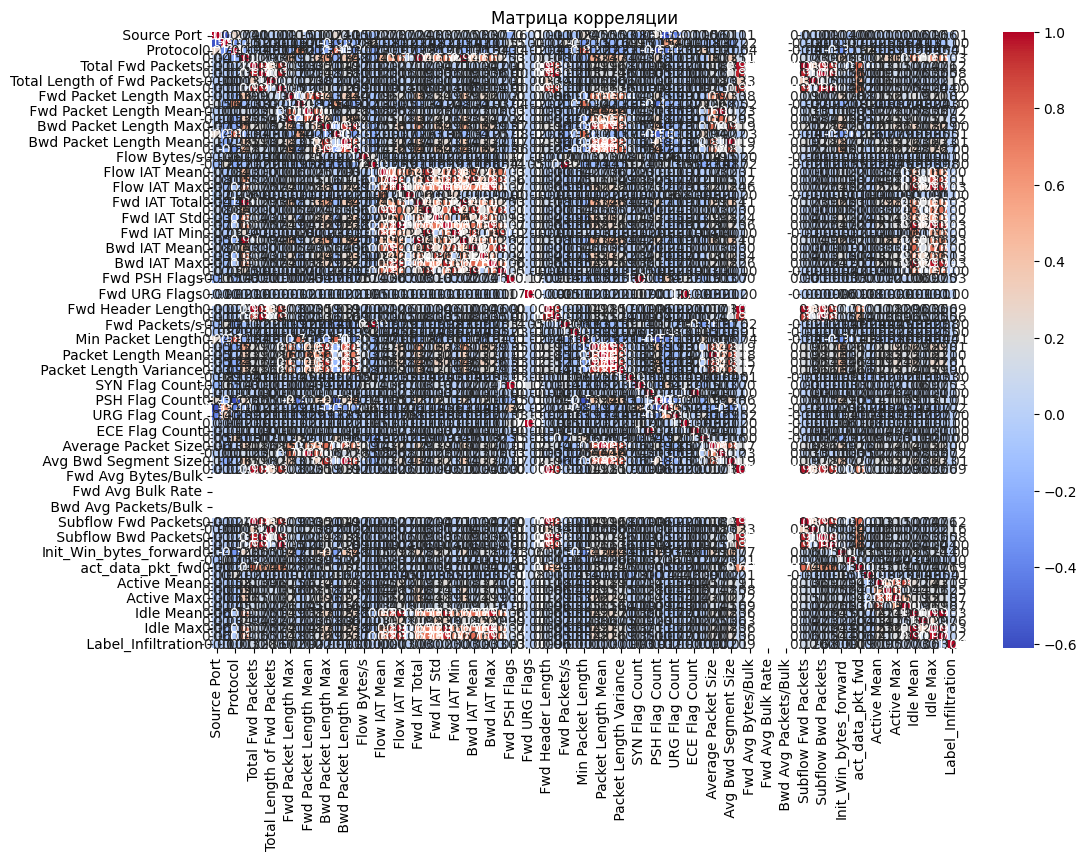

In [42]:
# 2. Рассчет матрицы корреляции
correlation_matrix = data.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Матрица корреляции')
plt.show()

# Отбор признаков с наивысшей абсолютной корреляцией с целевой переменной (например, 'Label')
target_variable = ' Label_Infiltration'  # Замените на имя вашей целевой переменной
correlation_with_target = correlation_matrix[target_variable].abs().sort_values(ascending=False)
high_correlation_features = correlation_with_target[correlation_with_target > 0.1].index.tolist()  # Отбор признаков с корреляцией > 0.1

X = data[high_correlation_features].drop(target_variable, axis=1): Здесь мы создаем DataFrame X, который содержит все признаки, отобранные на основе их высокой корреляции с целевой переменной. Метод drop используется для удаления целевой переменной из X, чтобы оставить только признаки для обучения модели.

y = data[target_variable]: Здесь мы определяем целевую переменную y, которая будет использоваться для обучения модели. Она содержит значения, которые мы хотим предсказать.

model = RandomForestClassifier(): Создается экземпляр модели случайного леса, которая является мощным алгоритмом для задач классификации и регрессии. Он работает путем создания множества деревьев решений и объединения их предсказаний.

model.fit(X_train, y_train): Здесь модель обучается на обучающей выборке. Метод fit принимает признаки X_train и целевую переменную y_train и настраивает модель на основе этих данных.

Оценка важности признаков:
feature_importances = model.feature_importances_: После обучения модели мы можем получить важность каждого признака, используя атрибут feature_importances_. Это значение показывает, насколько каждый признак влияет на предсказания модели.

important_features = pd.Series(feature_importances, index=X.columns).sort_values(ascending=False): Здесь мы создаем серию Pandas, где индексами являются названия признаков, а значениями — их важность. Затем мы сортируем эту серию по убыванию важности, чтобы увидеть, какие признаки наиболее значимы для модели.

In [45]:
# 3. Обучение модели машинного обучения
X = data[high_correlation_features].drop(target_variable, axis=1)  # Определяем признаки (X)
y = data[target_variable]  # Определяем целевую переменную (y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)  # Разделяем данные на обучающую и тестовую выборки

# Обучение модели
model = RandomForestClassifier()  # Создаем экземпляр модели случайного леса
model.fit(X_train, y_train)  # Обучаем модель на обучающей выборке

# Оценка важности признаков
feature_importances = model.feature_importances_  # Получаем важность признаков
important_features = pd.Series(feature_importances, index=X.columns).sort_values(ascending=False)  # Сортируем признаки по важности

Объясненная дисперсия — это мера, которая показывает, какую долю общей дисперсии данных объясняет модель или набор факторов. В контексте статистики и машинного обучения объясненная дисперсия помогает оценить, насколько хорошо модель описывает вариации в целевой переменной.

Когда мы говорим о дисперсии в общем смысле, мы имеем в виду, насколько сильно значения отклоняются от среднего. Объясненная дисперсия, в свою очередь, фокусируется на том, как хорошо модель может объяснить эти отклонения.

Применение метода главных компонент (PCA) для уменьшения размерности данных, сохраняя при этом максимальную объясненную дисперсию.

Здесь мы создаем экземпляр класса PCA, указывая параметр n_components=0.95. Это означает, что мы хотим сохранить 95% объясненной дисперсии данных. PCA будет автоматически определять, сколько главных компонент необходимо для достижения этого уровня объясненной дисперсии.

fit: Вычисляет главные компоненты на основе входных данных X, определяя, как много информации (дисперсии) они объясняют.

transform: Применяет найденные главные компоненты к данным X, создавая новый набор данных X_pca, который имеет меньшую размерность, но сохраняет большую часть информации.


explained_variance = pca.explained_variance_ratio_: Этот атрибут возвращает массив, где каждый элемент представляет долю объясненной дисперсии для соответствующей главной компоненты. Это позволяет понять, сколько информации сохраняется в каждой из главных компонент.

In [47]:
# 4. Применение метода главных компонент (PCA)
pca = PCA(n_components=0.95)  # Сохраняем 95% объясненной дисперсии
X_pca = pca.fit_transform(X)

# Объясненная дисперсия
explained_variance = pca.explained_variance_ratio_
print("Объясненная дисперсия главных компонент:", explained_variance)

Объясненная дисперсия главных компонент: [0.99999106]


Взаимная информация измеряет количество информации, которую один признак предоставляет о целевой переменной. Чем выше значение взаимной информации, тем больше информации о целевой переменной содержит данный признак. Это позволяет оценить, насколько каждый признак важен для предсказания целевой переменной.

In [49]:
# 5. Метод взаимной информации
mi = mutual_info_classif(X, y)  # Вычисляем взаимную информацию между признаками и целевой переменной
mi_series = pd.Series(mi, index=X.columns).sort_values(ascending=False)  # Создаем серию с взаимной информацией и сортируем по убыванию


Важность признаков по Random Forest:
 Subflow Fwd Bytes             0.388385
Total Length of Fwd Packets    0.373518
 act_data_pkt_fwd              0.084397
Subflow Fwd Packets            0.078968
 Total Fwd Packets             0.074732
dtype: float64

Взаимная информация:
 Total Fwd Packets             0.000846
Subflow Fwd Packets            0.000788
 act_data_pkt_fwd              0.000762
 Subflow Fwd Bytes             0.000473
Total Length of Fwd Packets    0.000459
dtype: float64


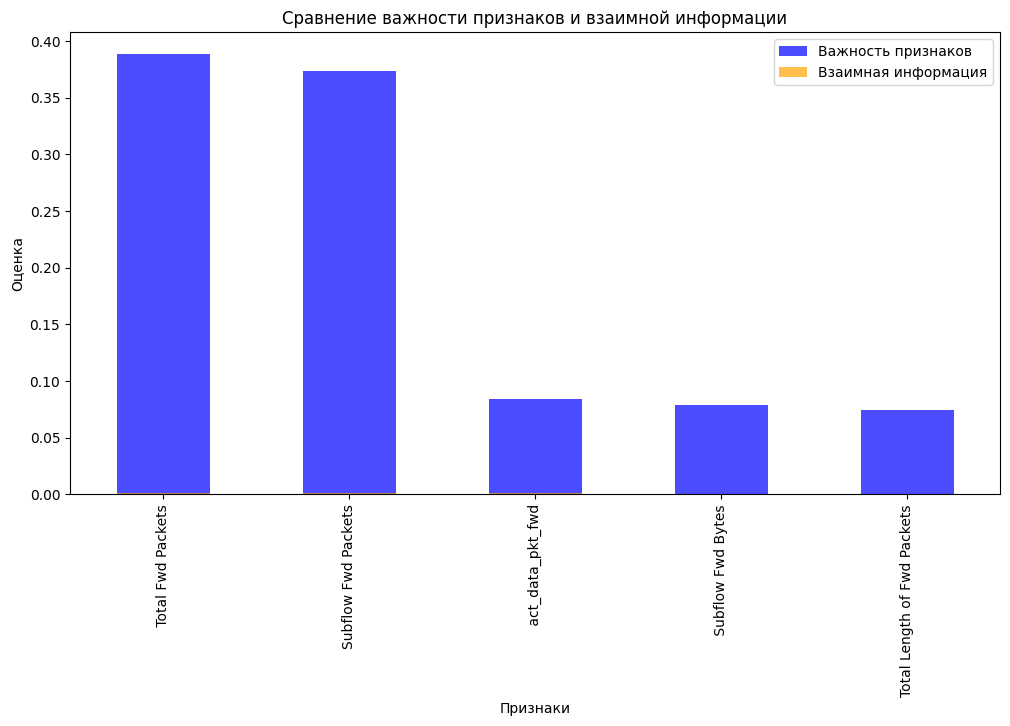

In [51]:
# 6. Сравнение результатов различных методов выбора признаков
print("Важность признаков по Random Forest:")
print(important_features.head(10))  # Выводим 10 наиболее важных признаков по Random Forest

print("\nВзаимная информация:")
print(mi_series.head(10))  # Выводим 10 признаков с наибольшей взаимной информацией

# Сравнение результатов
plt.figure(figsize=(12, 6))  # Устанавливаем размер графика
important_features.head(10).plot(kind='bar', color='blue', alpha=0.7, label='Важность признаков')  # Столбчатая диаграмма для важности признаков
mi_series.head(10).plot(kind='bar', color='orange', alpha=0.7, label='Взаимная информация')  # Столбчатая диаграмма для взаимной информации
plt.title('Сравнение важности признаков и взаимной информации')  # Заголовок графика
plt.xlabel('Признаки')  # Подпись оси X
plt.ylabel('Оценка')  # Подпись оси Y
plt.legend()  # Добавляем легенду
plt.show()  # Отображаем график
